In [ ]:
!pip install torchvision scikit-learn opencv-python matplotlib

In [2]:
#-------------------------------------------------- **第一區不可動,載入必要資料**-------------------------------------------------------------------
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random


# **載入 CIFAR-10 數據集並提取狗與卡車影像**
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


airplane_images, ship_images = [], []
for img, label in trainset:
    # dogs
    if label == 5 and len(airplane_images) < 5000:
        airplane_images.append(img.numpy())
    # trucks
    elif label == 9 and len(ship_images) < 5000:
        ship_images.append(img.numpy())
    if len(airplane_images) >= 5000 and len(ship_images) >= 5000:
        break

images = np.concatenate((airplane_images, ship_images), axis=0)
labels = np.array([0] * 5000 + [1] * 5000)
print(images.shape, labels.shape)



100%|██████████| 170M/170M [00:02<00:00, 60.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
(10000, 3, 32, 32) (10000,)


In [3]:

#-------------------------------------------------- **第二區可動，以下為同學自行提取特徵features**-------------------------------------------------------------------

import skimage.feature as skf

import cv2
import skimage.feature as skf
from tqdm import tqdm
import numpy as np
from skimage.feature import hog, local_binary_pattern

def extract_features(image):
    # Resize image to 32x32 (CIFAR-10 size)
    img = cv2.resize(image.transpose(1, 2, 0), (32, 32))  # Ensure size consistency
    img = (img * 255).astype(np.uint8)  # Normalize to 0–255

    features = []  # Store combined features

    # Color Histogram Features (HSV + LAB)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

    for color_space in [hsv_img, lab_img]:  # Extract from both spaces
        for i in range(3):  # 3 channels
            hist = cv2.calcHist([color_space], [i], None, [32], [0, 256])  # 32 bins
            hist = cv2.normalize(hist, hist).flatten()
            features.extend(hist)

    # HOG (Histogram of Oriented Gradients)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray_img,
                       orientations=12,              # Fewer orientations for smaller image
                       pixels_per_cell=(4, 4),       # Smaller cells for local features
                       cells_per_block=(4, 4),       # Block size
                       block_norm='L2-Hys',
                       feature_vector=True)
    features.extend(hog_features)

    # Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray_img, P=12, R=8, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 19), range=(0, 12))
    lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize
    features.extend(lbp_hist)

    # Edge Detection Features (Canny)
    edges = cv2.Canny(gray_img, 50, 200, apertureSize=3, L2gradient=True)  # Detect edges
    edge_hist, _ = np.histogram(edges.ravel(), bins=16, range=(0, 256))  # 16 bins
    edge_hist = edge_hist / edge_hist.sum()  # Normalize
    features.extend(edge_hist)

    # Texture Features (Gabor Filters)
    num_filters = 18
    for index in range(num_filters):
        n = (index % 6)+1
        theta = (np.pi / 6) * n
        kernel = cv2.getGaborKernel((2 + n, 2 + n), 1 + (index//2), theta, 6.0 + (index//2), 0.2 * (n), 0, ktype=cv2.CV_32F)
        filtered_img = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
        gabor_hist, _ = np.histogram(filtered_img.ravel(), bins=16, range=(0, 256))
        gabor_hist = gabor_hist / gabor_hist.sum()
        features.extend(gabor_hist)

    # Return as numpy array
    return np.array(features)


# 提取所有影像的特徵
features = np.array([extract_features(img) for img in images])

print(features.shape)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# features = scaler.fit_transform(features)

original_features = features

# Compute statistical features (mean, std, etc.) for the extracted features
# mean_features = np.mean(features, axis=1).reshape(-1, 1)
# std_features = np.std(features, axis=1).reshape(-1, 1)
# max_features = np.max(features, axis=1).reshape(-1, 1)
# min_features = np.min(features, axis=1).reshape(-1, 1)

# Concatenate additional features
# features = np.concatenate([features, mean_features, std_features, max_features, min_features], axis=1)
# print(features.shape)

# https://stackoverflow.com/questions/56445760/do-i-need-to-extract-feature-vectors-from-mnist-before-using-kmeans
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=150,
    learning_rate=200,
    max_iter=2000,
    random_state=42
)
print(features.shape)
features = tsne.fit_transform(features)


print(features.shape)

# plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels)
# plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels)
# plt.show()

# import pywt
# coeffs = pywt.wavedec(features, 'haar', level=3)

# Flatten all coefficients into one 1D array
# features = np.concatenate([np.ravel(c) for c in coeffs])

# print(features.shape)  # Resulting feature size

# features = features.reshape(-1, 1)  # Reshape to (n_samples, 1)


(10000, 5314)
(10000, 5314)
(10000, 2)


(10000, 2)


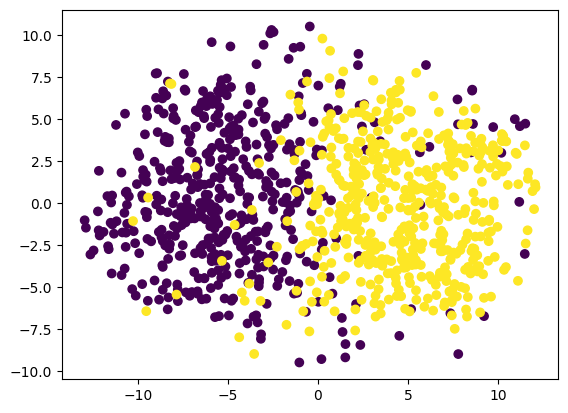

In [4]:
def show_tsne():
    print(features.shape)
    d = features.shape[1]

    if d == 2:
        plt.scatter(features[4500:5500, 0], features[4500:5500, 1], c=labels[4500:5500])
        plt.show()

    else:
        # Create a 3D scatter plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot data points
        scatter = ax.scatter(
            features[4500:5500, 0],  # X-axis
            features[4500:5500, 1],  # Y-axis
            features[4500:5500, 2],  # Z-axis
            c=labels[4500:5500],             # Color points based on labels
            cmap='viridis',       # Colormap
            s=60,                 # Size of points
            alpha=0.8             # Transparency
        )

        # Label axes
        ax.set_title('3D t-SNE Visualization')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')

        # Add color legend
        legend = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend)

        # Show the plot
        plt.show()

show_tsne()


K-means Clustering Accuracy: 88.10%


<Figure size 800x600 with 0 Axes>

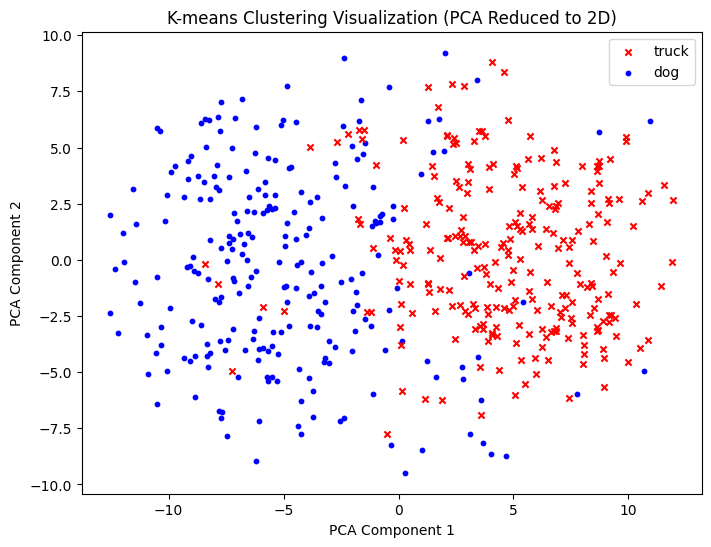

In [7]:
def predict():

#-------------------------------------------------- **第三區不可動,將features丟進Kmens裡面**-------------------------------------------------------------------
# **K-means 聚類**
    kmeans = KMeans(n_clusters=2, random_state=42)
    # kmeans.fit(features)
    kmeans.fit(original_features)
    predicted_labels = kmeans.labels_

    # 修正標籤與計算準確度
    if np.mean(predicted_labels[:5000]) > 0.5:
        predicted_labels = 1 - predicted_labels
    accuracy = accuracy_score(labels, predicted_labels)
    print(f"K-means Clustering Accuracy: {accuracy * 100:.2f}%")

    # **降維 (PCA)**
    pca = PCA(n_components=2)  # 將特徵降維到 2 維
    features_2d = pca.fit_transform(features)

    # **繪製分群結果，藍色圓圈與紅色叉叉，並添加圖例**
    plt.figure(figsize=(8, 6))

    # 隨機選取 100 個點的索引
    sample_indices = random.sample(range(features_2d.shape[0]), 500)

    # **繪製分群結果，藍色圓圈與紅色叉叉，並添加圖例**
    plt.figure(figsize=(8, 6))

    for i in sample_indices:
        if labels[i] == 0:
            plt.scatter(features_2d[i, 0], features_2d[i, 1], color='blue', marker='o', s=10, label='dog' if 'dog' not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            plt.scatter(features_2d[i, 0], features_2d[i, 1], color='red', marker='x', s=20, label='truck' if 'truck' not in plt.gca().get_legend_handles_labels()[1] else "")

    # 添加圖例，避免重複顯示
    plt.legend(loc='best')
    plt.title("K-means Clustering Visualization (PCA Reduced to 2D)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

predict()


Files already downloaded and verified


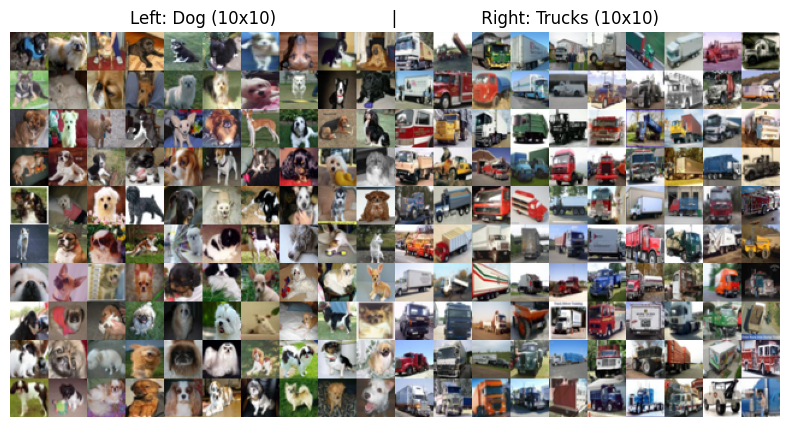

In [ ]:
#畫圖程式 可以刪掉
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# **載入 CIFAR-10 數據集並提取狗與卡車影像**
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

frog_images, truck_images = [], []
for img, label in trainset:
    if label == 5 and len(frog_images) < 100:  # 狗
        frog_images.append(img.numpy())
    elif label == 9 and len(truck_images) < 100:  # 卡車
        truck_images.append(img.numpy())
    if len(frog_images) >= 100 and len(truck_images) >= 100:
        break

# 將狗和卡車的影像排列成 10x10
frog_grid = np.concatenate([np.concatenate(frog_images[i * 10:(i + 1) * 10], axis=2) for i in range(10)], axis=1)
truck_grid = np.concatenate([np.concatenate(truck_images[i * 10:(i + 1) * 10], axis=2) for i in range(10)], axis=1)

# 合併左邊的狗和右邊的卡車
combined_image = np.concatenate((frog_grid, truck_grid), axis=2)

# 調整維度以適應 Matplotlib
combined_image = combined_image.transpose(1, 2, 0)

# 顯示結果
plt.figure(figsize=(10, 5))
plt.imshow(combined_image)
plt.title("Left: Dog (10x10)                      |                Right: Trucks (10x10)")
plt.axis('off')
plt.show()


# Test


In [ ]:

#-------------------------------------------------- **第二區可動，以下為同學自行提取特徵features**-------------------------------------------------------------------

import skimage.feature as skf

import cv2
import skimage.feature as skf
from tqdm import tqdm
import numpy as np
from skimage.feature import hog, local_binary_pattern

def extract_features(image):
    # Resize image to 32x32 (CIFAR-10 size)
    img = cv2.resize(image.transpose(1, 2, 0), (32, 32))  # Ensure size consistency
    img = (img * 255).astype(np.uint8)  # Normalize to 0–255

    features = []  # Store combined features

    # 1. Color Histogram Features (HSV + LAB)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

    for color_space in [hsv_img, lab_img]:  # Extract from both spaces
        for i in range(3):  # 3 channels
            hist = cv2.calcHist([color_space], [i], None, [32], [0, 256])  # 32 bins
            hist = cv2.normalize(hist, hist).flatten()
            features.extend(hist)

    # 2. HOG (Histogram of Oriented Gradients)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray_img,
                       orientations=16,              # Fewer orientations for smaller image
                       pixels_per_cell=(4, 4),       # Smaller cells for local features
                       cells_per_block=(4, 4),       # Block size
                       block_norm='L2-Hys',
                       feature_vector=True)
    features.extend(hog_features)

    # 3. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray_img, P=12, R=12, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 17), range=(0, 10))
    lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize
    features.extend(lbp_hist)

    # 4. Edge Detection Features (Canny)
    edges = cv2.Canny(gray_img, 50, 200, apertureSize=3, L2gradient=True)  # Detect edges
    edge_hist, _ = np.histogram(edges.ravel(), bins=16, range=(0, 256))  # 16 bins
    edge_hist = edge_hist / edge_hist.sum()  # Normalize
    features.extend(edge_hist)

    # 5. Texture Features (Gabor Filters)
    num_filters = 12
    for index in range(num_filters):
        n = (index % 4)+1
        theta = (np.pi / 4) * n
        kernel = cv2.getGaborKernel((2 + n, 2 + n), 1 + (index), theta, 6.0 + (index), 0.2 * (n), 0, ktype=cv2.CV_32F)
        filtered_img = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
        gabor_hist, _ = np.histogram(filtered_img.ravel(), bins=16, range=(0, 256))
        gabor_hist = gabor_hist / gabor_hist.sum()
        features.extend(gabor_hist)

    # Return as numpy array
    return np.array(features)


# 提取所有影像的特徵
features = np.array([extract_features(img) for img in images])

print(features.shape)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# features = scaler.fit_transform(features)

original_features = features

# Compute statistical features (mean, std, etc.) for the extracted features
# mean_features = np.mean(features, axis=1).reshape(-1, 1)
# std_features = np.std(features, axis=1).reshape(-1, 1)
# max_features = np.max(features, axis=1).reshape(-1, 1)
# min_features = np.min(features, axis=1).reshape(-1, 1)

# Concatenate additional features
# features = np.concatenate([features, mean_features, std_features, max_features, min_features], axis=1)
# print(features.shape)

# https://stackoverflow.com/questions/56445760/do-i-need-to-extract-feature-vectors-from-mnist-before-using-kmeans
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=150,
    learning_rate=200,
    max_iter=2000,
    random_state=42
)

print(features.shape)


features = tsne.fit_transform(features)
print(features.shape)

# plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels)
# plt.show()

# import pywt
# coeffs = pywt.wavedec(features, 'haar', level=3)

# Flatten all coefficients into one 1D array
# features = np.concatenate([np.ravel(c) for c in coeffs])

# print(features.shape)  # Resulting feature size

# features = features.reshape(-1, 1)  # Reshape to (n_samples, 1)

(10000, 6816)
(10000, 6816)
(10000, 2)


(10000, 2)


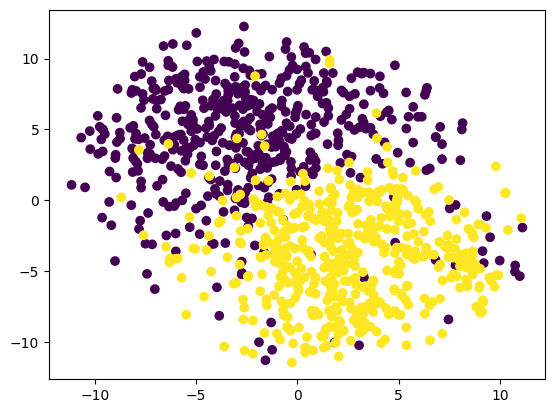

In [ ]:
show_tsne()

K-means Clustering Accuracy: 91.31%


<Figure size 800x600 with 0 Axes>

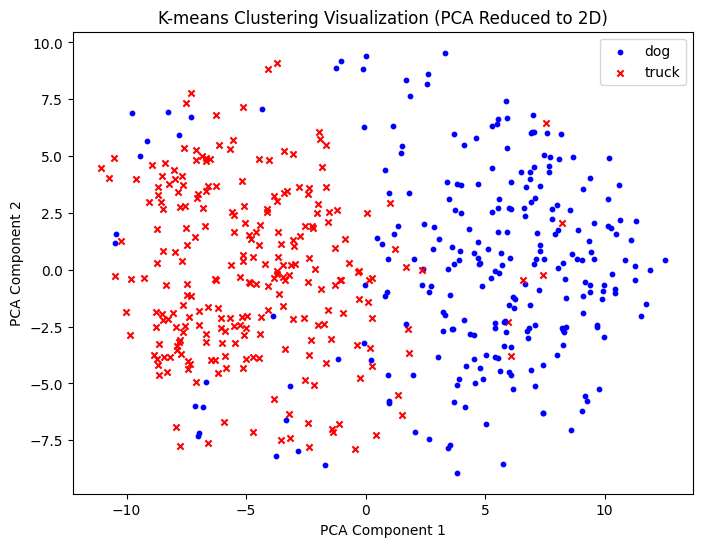

In [ ]:

def predict():
#-------------------------------------------------- **第三區不可動,將features丟進Kmens裡面**-------------------------------------------------------------------
# **K-means 聚類**
    kmeans = KMeans(n_clusters=2, random_state=42)
    # kmeans.fit(original_features)
    kmeans.fit(features)
    predicted_labels = kmeans.labels_

    # 修正標籤與計算準確度
    if np.mean(predicted_labels[:5000]) > 0.5:
        predicted_labels = 1 - predicted_labels
    accuracy = accuracy_score(labels, predicted_labels)
    print(f"K-means Clustering Accuracy: {accuracy * 100:.2f}%")

    # **降維 (PCA)**
    pca = PCA(n_components=2)  # 將特徵降維到 2 維
    features_2d = pca.fit_transform(features)

    # **繪製分群結果，藍色圓圈與紅色叉叉，並添加圖例**
    plt.figure(figsize=(8, 6))

    # 隨機選取 100 個點的索引
    sample_indices = random.sample(range(features_2d.shape[0]), 500)

    # **繪製分群結果，藍色圓圈與紅色叉叉，並添加圖例**
    plt.figure(figsize=(8, 6))

    for i in sample_indices:
        if labels[i] == 0:
            plt.scatter(features_2d[i, 0], features_2d[i, 1], color='blue', marker='o', s=10, label='dog' if 'dog' not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            plt.scatter(features_2d[i, 0], features_2d[i, 1], color='red', marker='x', s=20, label='truck' if 'truck' not in plt.gca().get_legend_handles_labels()[1] else "")

    # 添加圖例，避免重複顯示
    plt.legend(loc='best')
    plt.title("K-means Clustering Visualization (PCA Reduced to 2D)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

predict()
# K-means Clustering Accuracy: 90.74%


In [ ]:

#-------------------------------------------------- **第一區不可動,載入必要資料**-------------------------------------------------------------------
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random


# **載入 CIFAR-10 數據集並提取狗與卡車影像**
# transform = transforms.Compose([transforms.ToTensor()])
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

def get_data(n):


    airplane_images, ship_images = [], []
    for img, label in trainset:
        # dogs
        if label == 5 and len(airplane_images) < n:
            airplane_images.append(img.numpy())
        # trucks
        elif label == 9 and len(ship_images) < n:
            ship_images.append(img.numpy())
        if len(airplane_images) >= 5000 and len(ship_images) >= n:
            break

    images = np.concatenate((airplane_images, ship_images), axis=0)
    labels = np.array([0] * n + [1] * n)
    return images, labels



print(images.shape, labels.shape)


(160, 3, 32, 32) (160,)


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from skimage.feature import hog, local_binary_pattern
import itertools

# Hyperparameter grids
hog_params = {
    'orientations': [4, 6, 8, 10, 12],
    'pixels_per_cell': [(4, 4), (8, 8)],
    'cells_per_block': [(2, 2), (3, 3)]
}

lbp_params = {
    'P': [4, 8, 16, 32],
    'R': [1, 2, 4],
    'method': ['uniform', 'default']
}

best_accuracy = 0
best_params = {}

# Iterate over parameter combinations
for hog_param in itertools.product(hog_params['orientations'], hog_params['pixels_per_cell'], hog_params['cells_per_block']):
    for lbp_param in itertools.product(lbp_params['P'], lbp_params['R'], lbp_params['method']):

        # Feature extraction function
        def extract_features(image):
            # Convert image to a format suitable for OpenCV
            img = (image.transpose(1, 2, 0) * 255).astype(np.uint8)

            # # 1. Color Histogram Features
            hist_features = []
            for i in range(3):  # RGB channels
                hist = cv2.calcHist([img], [i], None, [32], [0, 256])  # 32 bins
                hist = cv2.normalize(hist, hist).flatten()
                hist_features.extend(hist)

            # 2. HOG Features
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            hog_features = hog(gray_img,
                               orientations=hog_param[0],
                               pixels_per_cell=hog_param[1],
                               cells_per_block=hog_param[2],
                               block_norm='L2-Hys',
                               feature_vector=True)

            # 3. LBP Features
            lbp = local_binary_pattern(gray_img, P=lbp_param[0], R=lbp_param[1], method=lbp_param[2])
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
            lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize histogram

            # Combine all features
            feature = np.concatenate([hist_features, hog_features, lbp_hist])
            return feature

        # Extract features for all images
        features = np.array([extract_features(img) for img in images])


        # Apply K-means clustering
        kmeans = KMeans(n_clusters=2, random_state=42)
        kmeans.fit(features)
        predicted_labels = kmeans.labels_

        # Adjust labels for accuracy
        if np.mean(predicted_labels[:5000]) > 0.5:
            predicted_labels = 1 - predicted_labels
        accuracy = accuracy_score(labels, predicted_labels)

        # Track best performance
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'hog': hog_param,
                'lbp': lbp_param
            }
            print(f"*New Best Accuracy: {accuracy:.2%} with {best_params}")
        else:
            best_params = {
                'hog': hog_param,
                'lbp': lbp_param
            }
            print(f"Accuracy: {accuracy:.2%} with {best_params}")


print(f"Best Accuracy: {best_accuracy:.2%}")
print(f"Best Parameters: {best_params}")


New Best Accuracy: 23.00% with {'hog': (4, (4, 4), (2, 2)), 'lbp': (4, 1, 'uniform')}
New Best Accuracy: 24.00% with {'hog': (4, (4, 4), (2, 2)), 'lbp': (16, 4, 'default')}
New Best Accuracy: 38.50% with {'hog': (4, (8, 8), (2, 2)), 'lbp': (4, 1, 'uniform')}
New Best Accuracy: 68.50% with {'hog': (6, (8, 8), (2, 2)), 'lbp': (32, 1, 'default')}
New Best Accuracy: 72.00% with {'hog': (8, (8, 8), (2, 2)), 'lbp': (4, 1, 'uniform')}
New Best Accuracy: 72.50% with {'hog': (8, (8, 8), (2, 2)), 'lbp': (16, 4, 'default')}
New Best Accuracy: 77.50% with {'hog': (12, (8, 8), (2, 2)), 'lbp': (4, 4, 'default')}
Best Accuracy: 77.50%
Best Parameters: {'hog': (12, (8, 8), (2, 2)), 'lbp': (4, 4, 'default')}


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from skimage.feature import hog, local_binary_pattern
import itertools
from sklearn.manifold import TSNE

# Hyperparameter grids
hog_params = {
    'orientations': [12, 14],
    'pixels_per_cell': [(4, 4), (6, 6)],
    'cells_per_block': [(2, 2), (3, 3)]
}

lbp_params = {
    'P': [1, 4, 8, 16],
    'R': [1, 4, 8, 16],
    'method': ['uniform']
}

tsne_params = {
    'perplexity': [20, 30, 50],  # Range of perplexities
    'learning_rate': [1, 10, 20],  # Learning rate choices
    'n_iter': [300, 500, 700],  # Number of iterations
    'n_components': [1, 2, 3]  # Dimensionality of the embedding
}

best_accuracy = 0
best_params = {}

# Iterate over parameter combinations
for hog_param in itertools.product(hog_params['orientations'], hog_params['pixels_per_cell'], hog_params['cells_per_block']):
    for lbp_param in itertools.product(lbp_params['P'], lbp_params['R'], lbp_params['method']):
        for tsne_param in itertools.product(tsne_params['perplexity'], tsne_params['learning_rate'], tsne_params['n_iter'], tsne_params['n_components']):

            # Extract t-SNE parameters from the tuple
            perplexity, learning_rate, n_iter, n_components = tsne_param

            # Feature extraction function
            def extract_features(image):
                # Convert image to a format suitable for OpenCV
                img = (image.transpose(1, 2, 0) * 255).astype(np.uint8)

                # 1. Color Histogram Features
                hist_features = []
                for i in range(3):  # RGB channels
                    hist = cv2.calcHist([img], [i], None, [32], [0, 256])  # 32 bins
                    hist = cv2.normalize(hist, hist).flatten()
                    hist_features.extend(hist)

                # 2. HOG Features
                gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                hog_features = hog(gray_img,
                                   orientations=hog_param[0],
                                   pixels_per_cell=hog_param[1],
                                   cells_per_block=hog_param[2],
                                   block_norm='L2-Hys',
                                   feature_vector=True)

                # 3. LBP Features
                lbp = local_binary_pattern(gray_img, P=lbp_param[0], R=lbp_param[1], method=lbp_param[2])
                lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
                lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize histogram

                # Combine all features
                feature = np.concatenate([hist_features, hog_features, lbp_hist])
                return feature

            # Extract features for all images
            features = np.array([extract_features(img) for img in images])

            # Apply t-SNE
            tsne = TSNE(
                n_components=n_components,
                perplexity=perplexity,
                learning_rate=learning_rate,
                max_iter=n_iter,
                random_state=42
            )
            features_tsne = tsne.fit_transform(features)

            # Apply K-means clustering
            kmeans = KMeans(n_clusters=2, random_state=42)
            kmeans.fit(features_tsne)
            predicted_labels = kmeans.labels_

            # Adjust labels for accuracy
            if np.mean(predicted_labels[:5000]) > 0.5:
                predicted_labels = 1 - predicted_labels
            accuracy = accuracy_score(labels, predicted_labels)

            # Track best performance
            if accuracy >= best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'hog': hog_param,
                    'lbp': lbp_param,
                    'tsne': {
                        'perplexity': perplexity,
                        'learning_rate': learning_rate,
                        'n_iter': n_iter,
                        'n_components': n_components
                    }
                }
                print(f"*New Best Accuracy: {accuracy:.2%} with {best_params}")

# After loop completes
print(f"Best Accuracy: {best_accuracy:.2%}")
print(f"Best Parameters: {best_params}")


# *New Best Accuracy: 88.75% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 4, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 2}}
# *New Best Accuracy: 89.38% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 4, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 2}}
# *New Best Accuracy: 90.00% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 8, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
# *New Best Accuracy: 89.50% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (4, 8, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 1, 'n_iter': 500, 'n_components': 3}}
#  Accuracy: 89.00% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (4, 8, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
# *New Best Accuracy: 88.50% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 4, 'uniform'), 'tsne': {'perplexity': 30, 'learning_rate': 10, 'n_iter': 500, 'n_components': 2}}ning_rate': 1, 'n_iter': 500, 'n_components': 3}}


*New Best Accuracy: 86.25% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 1, 'n_iter': 300, 'n_components': 1}}
*New Best Accuracy: 86.25% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 1, 'n_iter': 300, 'n_components': 2}}
*New Best Accuracy: 86.88% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 1, 'n_iter': 500, 'n_components': 1}}
*New Best Accuracy: 86.88% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 1, 'n_iter': 500, 'n_components': 3}}
*New Best Accuracy: 86.88% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 1, 'n_iter': 700, 'n_components': 1}}
*New Best Accuracy: 86.88% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 1, 'n_iter': 700, 

KeyboardInterrupt: 

*New Best Accuracy: 86.88% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 20, 'n_iter': 300, 'n_components': 2}}
*New Best Accuracy: 87.50% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 20, 'n_iter': 500, 'n_components': 2}}
*New Best Accuracy: 87.50% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
*New Best Accuracy: 87.50% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 20, 'n_iter': 700, 'n_components': 2}}
*New Best Accuracy: 87.50% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3}}
*New Best Accuracy: 87.50% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 1, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter':

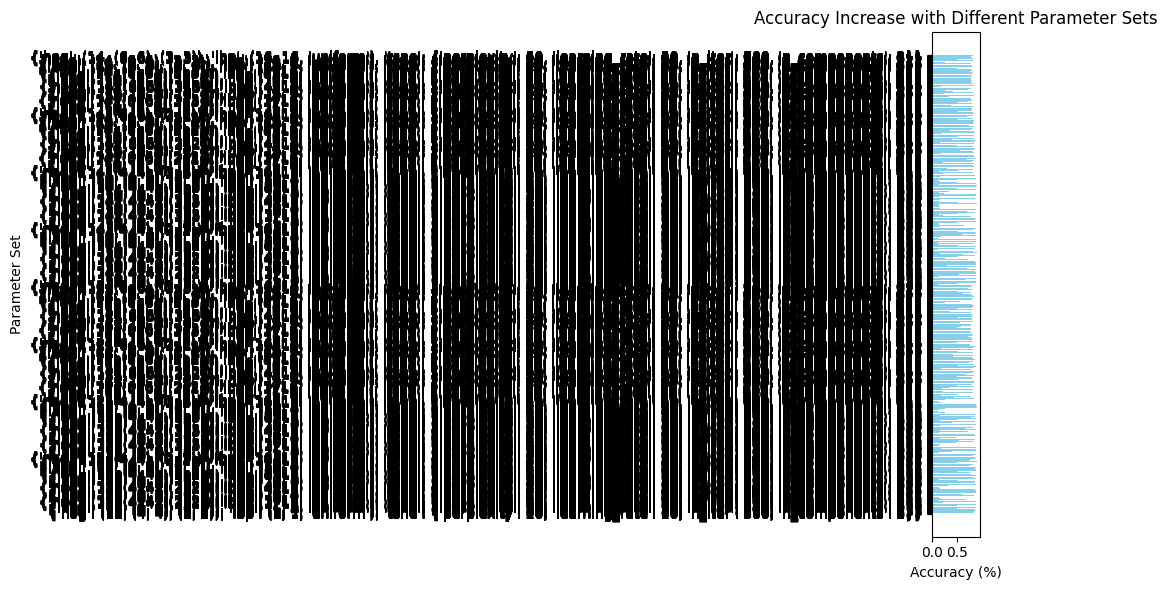

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from skimage.feature import hog, local_binary_pattern
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Hyperparameter grids
hog_params = {
    'orientations': [14, 16],
    'pixels_per_cell': [(2, 2), (4, 4), (8, 8)],
    'cells_per_block': [(3, 3)]
}

# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 300, 'n_components': 3}}
# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3}}

lbp_params = {
    'P': [8, 16, 32],
    'R': [8, 16, 32],
    'method': ['uniform']
}

tsne_params = {
    'perplexity': [20, 50],  # Range of perplexities
    'learning_rate': [20, 50],  # Learning rate choices
    'n_iter': [300, 500, 700],  # Number of iterations
    'n_components': [2, 3]  # Dimensionality of the embedding
}

# List to store accuracies and parameter sets
accuracy_history = []

best_accuracy = 0
best_params = {}

# Iterate over parameter combinations
for hog_param in itertools.product(hog_params['orientations'], hog_params['pixels_per_cell'], hog_params['cells_per_block']):
    for lbp_param in itertools.product(lbp_params['P'], lbp_params['R'], lbp_params['method']):
        for tsne_param in itertools.product(tsne_params['perplexity'], tsne_params['learning_rate'], tsne_params['n_iter'], tsne_params['n_components']):

            # Extract t-SNE parameters from the tuple
            perplexity, learning_rate, n_iter, n_components = tsne_param

            # Feature extraction function
            def extract_features(image):
                # Convert image to a format suitable for OpenCV
                img = (image.transpose(1, 2, 0) * 255).astype(np.uint8)

                # 1. Color Histogram Features
                hist_features = []
                for i in range(3):  # RGB channels
                    hist = cv2.calcHist([img], [i], None, [32], [0, 256])  # 32 bins
                    hist = cv2.normalize(hist, hist).flatten()
                    hist_features.extend(hist)

                # 2. HOG Features
                gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                hog_features = hog(gray_img,
                                   orientations=hog_param[0],
                                   pixels_per_cell=hog_param[1],
                                   cells_per_block=hog_param[2],
                                   block_norm='L2-Hys',
                                   feature_vector=True)

                # 3. LBP Features
                lbp = local_binary_pattern(gray_img, P=lbp_param[0], R=lbp_param[1], method=lbp_param[2])
                lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
                lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize histogram

                # Combine all features
                feature = np.concatenate([hist_features, hog_features, lbp_hist])
                return feature

            # Extract features for all images
            features = np.array([extract_features(img) for img in images])

            # Apply t-SNE
            tsne = TSNE(
                n_components=n_components,
                perplexity=perplexity,
                learning_rate=learning_rate,
                max_iter=n_iter,
                random_state=42
            )
            features_tsne = tsne.fit_transform(features)

            # Apply K-means clustering
            kmeans = KMeans(n_clusters=2, random_state=42)
            kmeans.fit(features_tsne)
            predicted_labels = kmeans.labels_

            # Adjust labels for accuracy
            if np.mean(predicted_labels[:5000]) > 0.5:
                predicted_labels = 1 - predicted_labels
            accuracy = accuracy_score(labels, predicted_labels)

            # Store the parameter set and accuracy
            # Track best performance
            if accuracy >= best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'hog': hog_param,
                    'lbp': lbp_param,
                    'tsne': {
                        'perplexity': perplexity,
                        'learning_rate': learning_rate,
                        'n_iter': n_iter,
                        'n_components': n_components
                    }
                }
                print(f"*New Best Accuracy: {accuracy:.2%} with {best_params}")

                accuracy_history.append({
                    'accuracy': accuracy,
                    'params': {
                        'hog': hog_param,
                        'lbp': lbp_param,
                        'tsne': {
                            'perplexity': perplexity,
                            'learning_rate': learning_rate,
                            'n_iter': n_iter,
                            'n_components': n_components
                        }
                    }
                })


# After loop completes
print(f"Best Accuracy: {best_accuracy:.2%}")
print(f"Best Parameters: {best_params}")

# Extract accuracies for plotting
accuracies = [entry['accuracy'] for entry in accuracy_history]
param_sets = [str(entry['params']) for entry in accuracy_history]
print(f'len(accuracies) : {len(accuracies)}')

# Plot the accuracy increase
plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracies)), accuracies, color='skyblue')
plt.xlabel('')
plt.ylabel('')
plt.title('Accuracy Increase with Different Parameter Sets')
plt.tight_layout()
plt.show()

# *New Best Accuracy: 90.00% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 8, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
# *New Best Accuracy: 90.00% with {'hog': (12, (4, 4), (2, 2)), 'lbp': (1, 8, 'uniform'), 'tsne': {'perplexity': 20, 'learning_rate': 50, 'n_iter': 500, 'n_components': 2}}
# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (4, 8, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 2}}
# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 1, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 2}}
# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 1, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 2}}
# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 300, 'n_components': 3}}
# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3}}


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from skimage.feature import hog, local_binary_pattern
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Hyperparameter grids
hog_params = {
    'orientations': [14, 16, 18],
    'pixels_per_cell': [(4, 4)],
    'cells_per_block': [(3, 3), (4, 4)]
}

# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 300, 'n_components': 3}}
# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3}}


# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (16, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 75, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}

# lbp_params = {
#     'P': [8, 16, 32],
#     'R': [8, 16, 32],
#     'method': ['uniform']
# }

# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 12}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 20}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 40}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'manhattan', 'early_exaggeration': 12}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'manhattan', 'early_exaggeration': 20}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'manhattan', 'early_exaggeration': 40}}

lbp_params = {
    'P': [8, 16, 24],
    'R': [1, 3 , 8, 12, 16],
    'method': ['uniform', 'default'],
}

tsne_params = {
    'perplexity': [50 ,75],  # Range of perplexities
    'learning_rate': [20, 35, 50],  # Learning rate choices
    'n_iter': [700],  # Number of iterations
    'n_components': [3],  # Dimensionality of the embedding
    'metrix': ['euclidean'],  # Dimensionality of the embedding
    'early_exaggeration': [100],
}

# List to store accuracies and parameter sets
accuracy_history = []

best_accuracy = 0
best_params = {}

# Iterate over parameter combinations
for hog_param in itertools.product(hog_params['orientations'], hog_params['pixels_per_cell'], hog_params['cells_per_block']):
    for tsne_param in itertools.product(tsne_params['perplexity'], tsne_params['learning_rate'], tsne_params['n_iter'], tsne_params['n_components'], tsne_params['metrix'], tsne_params['early_exaggeration']):
        for lbp_param in itertools.product(lbp_params['P'], lbp_params['R'], lbp_params['method']):

            # Extract t-SNE parameters from the tuple
            perplexity, learning_rate, n_iter, n_components, metrix, early_exaggeration = tsne_param

            # Feature extraction function
            def extract_features(image):
                # Convert image to a format suitable for OpenCV
                img = (image.transpose(1, 2, 0) * 255).astype(np.uint8)

                # 1. Color Histogram Features
                hist_features = []
                for i in range(3):  # RGB channels
                    hist = cv2.calcHist([img], [i], None, [32], [0, 256])  # 32 bins
                    hist = cv2.normalize(hist, hist).flatten()
                    hist_features.extend(hist)

                # 2. HOG Features
                gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                hog_features = hog(gray_img,
                                   orientations=hog_param[0],
                                   pixels_per_cell=hog_param[1],
                                   cells_per_block=hog_param[2],
                                   block_norm='L2-Hys',
                                   feature_vector=True)

                # 3. LBP Features
                lbp = local_binary_pattern(gray_img, P=lbp_param[0], R=lbp_param[1], method=lbp_param[2])
                lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
                lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize histogram

                # Combine all features
                feature = np.concatenate([hist_features, hog_features, lbp_hist])
                # feature = np.concatenate([hog_features, lbp_hist])
                return feature

            # Extract features for all images
            features = np.array([extract_features(img) for img in images])

            # Apply t-SNE
            tsne = TSNE(
                n_components=n_components,
                perplexity=perplexity,
                learning_rate=learning_rate,
                max_iter=n_iter,
                random_state=42
            )
            features_tsne = tsne.fit_transform(features)

            # Apply K-means clustering
            kmeans = KMeans(n_clusters=2, random_state=42)
            kmeans.fit(features_tsne)
            predicted_labels = kmeans.labels_

            # Adjust labels for accuracy
            if np.mean(predicted_labels[:5000]) > 0.5:
                predicted_labels = 1 - predicted_labels
            accuracy = accuracy_score(labels, predicted_labels)

            show_all = True

            # Store the parameter set and accuracy
            # Track best performance
            if accuracy >= best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'hog': hog_param,
                    'lbp': lbp_param,
                    'tsne': {
                        'perplexity': perplexity,
                        'learning_rate': learning_rate,
                        'n_iter': n_iter,
                        'n_components': n_components,
                        'metrix': metrix,
                        'early_exaggeration': early_exaggeration,
                    }
                }
                print(f"*New Best Accuracy: {accuracy:.2%} with {best_params}")

                accuracy_history.append({
                    'accuracy': accuracy,
                    'params': {
                        'hog': hog_param,
                        'lbp': lbp_param,
                        'tsne': {
                            'perplexity': perplexity,
                            'learning_rate': learning_rate,
                            'n_iter': n_iter,
                            'n_components': n_components,
                            'metrix': metrix,
                            'early_exaggeration': early_exaggeration,
                        }
                    }
                })
            elif(show_all):
                best_params = {
                    'hog': hog_param,
                    'lbp': lbp_param,
                    'tsne': {
                        'perplexity': perplexity,
                        'learning_rate': learning_rate,
                        'n_iter': n_iter,
                        'n_components': n_components,
                        'metrix': metrix,
                        'early_exaggeration': early_exaggeration,
                    }
                }
                print(f"Accuracy: {accuracy:.2%} with {best_params}")


# After loop completes
print(f"Best Accuracy: {best_accuracy:.2%}")
print(f"Best Parameters: {best_params}")

# Extract accuracies for plotting
accuracies = [entry['accuracy'] for entry in accuracy_history]
param_sets = [str(entry['params']) for entry in accuracy_history]
print(f'len(accuracies) : {len(accuracies)}')

# Plot the accuracy increase
plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracies)), accuracies, color='skyblue')
plt.xlabel('')
plt.ylabel('')
plt.title('Accuracy Increase with Different Parameter Sets')
plt.tight_layout()
plt.show()

# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (16, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 75, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}

# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (16, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 75, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}




*New Best Accuracy: 83.75% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 1, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 100}}
Accuracy: 14.37% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 1, 'default'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 100}}
Accuracy: 18.12% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 3, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 100}}
*New Best Accuracy: 83.75% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 3, 'default'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 100}}
*New Best Accuracy: 83.75% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 8, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 

KeyboardInterrupt: 

# Fianl


In [ ]:
images, labels = get_data(50)
print(images.shape, labels.shape)


(100, 3, 32, 32) (100,)


*New Best Accuracy: 56.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 1000, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 100}}
Accuracy: 11.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 1000, 'n_components': 2, 'metrix': 'euclidean', 'early_exaggeration': 100}}
Accuracy: 51.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 250, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 100}}
Accuracy: 51.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 250, 'n_components': 2, 'metrix': 'euclidean', 'early_exaggeration': 100}}
Accuracy: 55.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter'

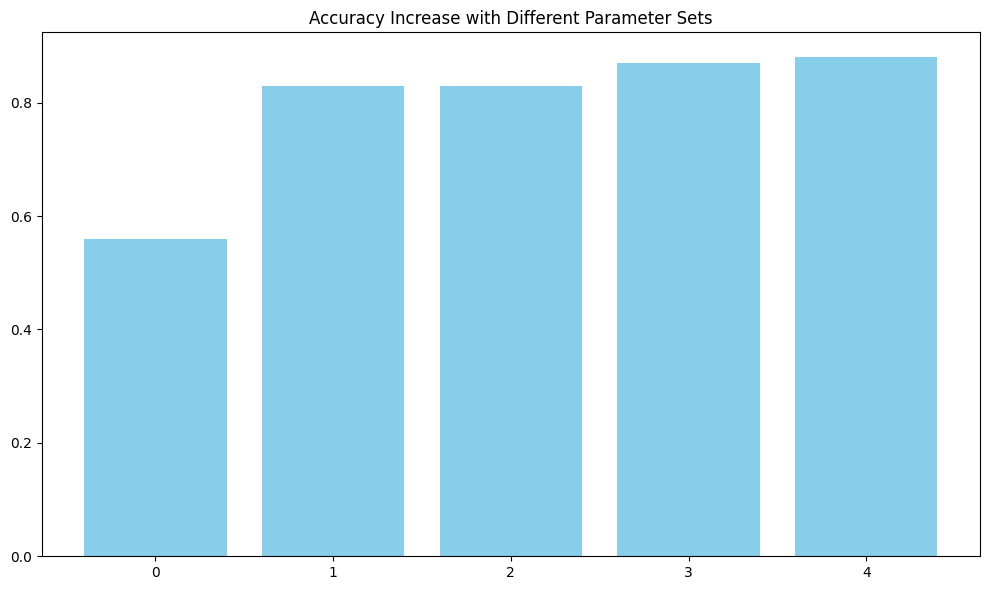

In [ ]:

import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from skimage.feature import hog, local_binary_pattern
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Hyperparameter grids

# lbp_params = {
#     'P': [8, 16, 32],
#     'R': [8, 16, 32],
#     'method': ['uniform']
# }

hog_params = {
    'orientations': [14],
    'pixels_per_cell': [(4, 4)],
    'cells_per_block': [(4, 4)]
}


lbp_params = {
    'P': [12],
    'R': [12],
    'method': ['uniform'],
}

tsne_params = {
    'perplexity': [50, 40],
    'learning_rate': [20, 10, 1, 40, 100],
    'n_iter': [1000, 250, 500],
    'n_components': [3, 2],
    'metrix': ['euclidean'],
    'early_exaggeration': [100],
}

# List to store accuracies and parameter sets
accuracy_history = []

best_accuracy = 0
best_params = {}

# Iterate over parameter combinations
for hog_param in itertools.product(hog_params['orientations'], hog_params['pixels_per_cell'], hog_params['cells_per_block']):
    for tsne_param in itertools.product(tsne_params['perplexity'], tsne_params['learning_rate'], tsne_params['n_iter'], tsne_params['n_components'], tsne_params['metrix'], tsne_params['early_exaggeration']):
        for lbp_param in itertools.product(lbp_params['P'], lbp_params['R'], lbp_params['method']):

            # Extract t-SNE parameters from the tuple
            perplexity, learning_rate, n_iter, n_components, metrix, early_exaggeration = tsne_param


            def extract_features(image):
                # Resize image to 32x32 (CIFAR-10 size)
                img = cv2.resize(image.transpose(1, 2, 0), (32, 32))  # Ensure size consistency
                img = (img * 255).astype(np.uint8)  # Normalize to 0–255

                features = []  # Store combined features

                # 1. Color Histogram Features (HSV + LAB)
                # Convert to HSV and LAB for better color representation
                hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

                for color_space in [hsv_img , lab_img]:  # Extract from both spaces
                    for i in range(3):  # 3 channels
                        hist = cv2.calcHist([color_space], [i], None, [48], [0, 256])  # 32 bins
                        hist = cv2.normalize(hist, hist).flatten()
                        features.extend(hist)

                # 2. HOG (Histogram of Oriented Gradients)
                gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                hog_features = hog(gray_img,
                                   orientations=hog_param[0],
                                   pixels_per_cell=hog_param[1],
                                   cells_per_block=hog_param[2],
                                   block_norm='L2-Hys',
                                   feature_vector=True)
                features.extend(hog_features)

                # 3. Local Binary Pattern (LBP)
                lbp = local_binary_pattern(gray_img, P=lbp_param[0], R=lbp_param[1], method=lbp_param[2])
                lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
                lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize histogram
                features.extend(lbp_hist)

                # 4. Edge Detection Features (Canny)
                edges = cv2.Canny(gray_img, 50, 150)  # Detect edges
                edge_hist, _ = np.histogram(edges.ravel(), bins=16, range=(0, 256))  # 16 bins
                edge_hist = edge_hist / edge_hist.sum()  # Normalize
                features.extend(edge_hist)

                # 5. Texture Features (Gabor Filters)
                # num_filters = 4
                # for theta in range(num_filters):
                #     theta = theta / num_filters * np.pi
                #     kernel = cv2.getGaborKernel((7, 7), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
                #     filtered_img = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
                #     gabor_hist, _ = np.histogram(filtered_img.ravel(), bins=16, range=(0, 256))
                #     gabor_hist = gabor_hist / gabor_hist.sum()
                #     features.extend(gabor_hist)

                # Return as numpy array
                return np.array(features)


            # Extract features for all images
            features = np.array([extract_features(img) for img in images])

            # Apply t-SNE
            tsne = TSNE(
                n_components=n_components,
                perplexity=perplexity,
                learning_rate=learning_rate,
                max_iter=n_iter,
                random_state=42
            )
            features_tsne = tsne.fit_transform(features)

            # Apply K-means clustering
            kmeans = KMeans(n_clusters=2, random_state=42)
            kmeans.fit(features_tsne)
            predicted_labels = kmeans.labels_

            # Adjust labels for accuracy
            if np.mean(predicted_labels[:5000]) > 0.5:
                predicted_labels = 1 - predicted_labels
            accuracy = accuracy_score(labels, predicted_labels)

            show_all = True

            # Store the parameter set and accuracy
            # Track best performance
            if accuracy >= best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'hog': hog_param,
                    'lbp': lbp_param,
                    'tsne': {
                        'perplexity': perplexity,
                        'learning_rate': learning_rate,
                        'n_iter': n_iter,
                        'n_components': n_components,
                        'metrix': metrix,
                        'early_exaggeration': early_exaggeration,
                    }
                }
                print(f"*New Best Accuracy: {accuracy:.2%} with {best_params}")

                accuracy_history.append({
                    'accuracy': accuracy,
                    'params': {
                        'hog': hog_param,
                        'lbp': lbp_param,
                        'tsne': {
                            'perplexity': perplexity,
                            'learning_rate': learning_rate,
                            'n_iter': n_iter,
                            'n_components': n_components,
                            'metrix': metrix,
                            'early_exaggeration': early_exaggeration,
                        }
                    }
                })
            elif(show_all):
                params = {
                    'hog': hog_param,
                    'lbp': lbp_param,
                    'tsne': {
                        'perplexity': perplexity,
                        'learning_rate': learning_rate,
                        'n_iter': n_iter,
                        'n_components': n_components,
                        'metrix': metrix,
                        'early_exaggeration': early_exaggeration,
                    }
                }
                print(f"Accuracy: {accuracy:.2%} with {params}")


# After loop completes
print(f"Best Accuracy: {best_accuracy:.2%}")
print(f"Best Parameters: {best_params}")

# Extract accuracies for plotting
accuracies = [entry['accuracy'] for entry in accuracy_history]
param_sets = [str(entry['params']) for entry in accuracy_history]
print(f'len(accuracies) : {len(accuracies)}')

# Plot the accuracy increase
plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracies)), accuracies, color='skyblue')
plt.xlabel('')
plt.ylabel('')
plt.title('Accuracy Increase with Different Parameter Sets')
plt.tight_layout()
plt.show()

# Best Parameters: {'hog': (16, (4, 4), (4, 4)), 'lbp': (16, 16, 'uniform'), 'tsne': {'perplexity': 40, 'learning_rate': 50, 'n_iter': 700, 'n_components': 3, 'metrix': 'euclidean', 'early_exaggeration': 100}})

# *New Best Accuracy: 90.62% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 700, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (16, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 75, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}

# *New Best Accuracy: 90.00% with {'hog': (14, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 50, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}
# *New Best Accuracy: 90.62% with {'hog': (16, (4, 4), (3, 3)), 'lbp': (8, 16, 'uniform'), 'tsne': {'perplexity': 75, 'learning_rate': 20, 'n_iter': 500, 'n_components': 3}}


In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog, local_binary_pattern
import cv2
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Parameter Grids

hog_params = {
    'orientations': [14],
    'pixels_per_cell': [(4, 4)],
    'cells_per_block': [(4, 4)]
}


lbp_params = {
    'P': [12],
    'R': [12],
    'method': ['uniform'],
}

gabor_params = {
    'kernel_size': [(5, 5), (7, 7), (11, 11)],  # Kernel size
    'sigma': [1.0, 3.0, 5.0],  # Standard deviation
    'theta': [6, 10],  # Orientation
    'lambda': [4.0, 10.0, 20],  # Wavelength
    'gamma': [0.5, 0.7, 1.0]  # Aspect ratio
}

tsne_params = {
    'perplexity': [50],
    'learning_rate': [20],
    'n_iter': [1000],
    'n_components': [2, 3],
    'metric': ['euclidean'],
    'early_exaggeration': [24]
}

# Tracking results
accuracy_history = []
best_accuracy = 0
best_params = {}

# Grid Search
for hog_param in itertools.product(hog_params['orientations'], hog_params['pixels_per_cell'], hog_params['cells_per_block']):
    for tsne_param in itertools.product(tsne_params['perplexity'], tsne_params['learning_rate'], tsne_params['n_iter'], tsne_params['n_components'], tsne_params['metric'], tsne_params['early_exaggeration']):
        for lbp_param in itertools.product(lbp_params['P'], lbp_params['R'], lbp_params['method']):
            for gabor_param in itertools.product(gabor_params['kernel_size'], gabor_params['sigma'], gabor_params['theta'], gabor_params['lambda'], gabor_params['gamma']):

                # Extract t-SNE parameters
                perplexity, learning_rate, n_iter, n_components, metric, early_exaggeration = tsne_param

                # Feature extraction function
                def extract_features(image):
                    img = cv2.resize(image.transpose(1, 2, 0), (32, 32))  # Resize for CIFAR-10
                    img = (img * 255).astype(np.uint8)

                    features = []

                    # 1. Color Histogram
                    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

                    for color_space in [hsv_img, lab_img]:
                        for i in range(3):
                            hist = cv2.calcHist([color_space], [i], None, [48], [0, 256])
                            hist = cv2.normalize(hist, hist).flatten()
                            features.extend(hist)

                    # 2. HOG Features
                    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                    hog_features = hog(gray_img,
                                       orientations=hog_param[0],
                                       pixels_per_cell=hog_param[1],
                                       cells_per_block=hog_param[2],
                                       block_norm='L2-Hys',
                                       feature_vector=True)
                    features.extend(hog_features)

                    # 3. LBP Features
                    lbp = local_binary_pattern(gray_img, P=lbp_param[0], R=lbp_param[1], method=lbp_param[2])
                    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
                    lbp_hist = lbp_hist / lbp_hist.sum()
                    features.extend(lbp_hist)

                # num_filters = 4
                # for theta in range(num_filters):
                #     theta = theta / num_filters * np.pi
                #     kernel = cv2.getGaborKernel((7, 7), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
                #     filtered_img = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
                #     gabor_hist, _ = np.histogram(filtered_img.ravel(), bins=16, range=(0, 256))
                #     gabor_hist = gabor_hist / gabor_hist.sum()
                #     features.extend(gabor_hist

                    kernel_size, sigma, num_filters, lambd, gamma = gabor_param
                    for theta in range(num_filters):
                        a_theta = theta / num_filters * np.pi
                        # kernel = cv2.getGaborKernel((5, 5), 3.5, theta, 8.0, 0.6, 0, ktype=cv2.CV_32F)

                    # 4. Gabor Filter Features
                        kernel = cv2.getGaborKernel(kernel_size, sigma, a_theta, lambd, gamma, ktype=cv2.CV_32F)

                        filtered_img = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
                        gabor_hist, _ = np.histogram(filtered_img.ravel(), bins=16, range=(0, 256))
                        gabor_hist = gabor_hist / gabor_hist.sum()
                        features.extend(gabor_hist)

                    return np.array(features)

                # Extract features from images
                features = np.array([extract_features(img) for img in images])

                # Normalize features
                features = StandardScaler().fit_transform(features)

                # Apply t-SNE
                tsne = TSNE(
                    n_components=n_components,
                    perplexity=perplexity,
                    learning_rate=learning_rate,
                    max_iter=n_iter,
                    metric=metric,
                    early_exaggeration=early_exaggeration,
                    random_state=42
                )
                features_tsne = tsne.fit_transform(features)

                # Clustering using K-means
                kmeans = KMeans(n_clusters=2, random_state=42)
                predicted_labels = kmeans.fit_predict(features_tsne)

                # Calculate Accuracy
                if np.mean(predicted_labels[:5000]) > 0.5:
                    predicted_labels = 1 - predicted_labels
                accuracy = accuracy_score(labels, predicted_labels)

                # Track best performance
                if accuracy >= best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'hog': hog_param,
                        'lbp': lbp_param,
                        'gabor': gabor_param,
                        'tsne': tsne_param
                    }
                    print(f"*New Best Accuracy: {accuracy:.2%} with {best_params}")
                    accuracy_history.append({'accuracy': accuracy, 'params': best_params})
                else:
                    params = {
                        'hog': hog_param,
                        'lbp': lbp_param,
                        'gabor': gabor_param,
                        'tsne': tsne_param
                    }
                    print(f"\tAccuracy: {accuracy:.2%} with {params}")

# Final Output
print(f"Best Accuracy: {best_accuracy:.2%}")
print(f"Best Parameters: {best_params}")

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.title('t-SNE Visualization of Clusters')
plt.show()


*New Best Accuracy: 20.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'gabor': ((5, 5), 1.0, 6, 4.0, 0.5), 'tsne': (50, 20, 1000, 2, 'euclidean', 24)}
*New Best Accuracy: 22.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'gabor': ((5, 5), 1.0, 6, 4.0, 0.7), 'tsne': (50, 20, 1000, 2, 'euclidean', 24)}
	Accuracy: 21.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'gabor': ((5, 5), 1.0, 6, 4.0, 1.0), 'tsne': (50, 20, 1000, 2, 'euclidean', 24)}
	Accuracy: 21.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'gabor': ((5, 5), 1.0, 6, 10.0, 0.5), 'tsne': (50, 20, 1000, 2, 'euclidean', 24)}
	Accuracy: 20.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'gabor': ((5, 5), 1.0, 6, 10.0, 0.7), 'tsne': (50, 20, 1000, 2, 'euclidean', 24)}
	Accuracy: 19.00% with {'hog': (14, (4, 4), (4, 4)), 'lbp': (12, 12, 'uniform'), 'gabor': ((5, 5), 1.0, 6, 10.0, 1.0), 'tsne': (50, 20, 1000, 2, 'euclidean', 24)}
	Accura

KeyboardInterrupt: 